# SAC함수를 이용한 Mujoco humanoid 구현
SAC 알고리즘의 목표:
SAC의 주요 목표는 actor의 엔트로피를 최대화하면서 기대 보상을 최대화하는 것입니다. 이는 엔트로피를 최대화함으로써 탐험(exploration)과 강건성(robustness)을 크게 향상시킬 수 있기 때문에 학습 효율성과 안정성을 기대할 수 있습니다.

SAC의 목적 함수:
$\sum_t \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t)]$
SAC는 일반적인 강화 학습 목적 함수를 확장한 목적 함수를 고려합니다. 이 함수는 정책의 기대 엔트로피를 목적 함수에 추가하여 확률적인 정책을 선호합니다.

$$J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))].$$

주요 개념:
<br><br>
온도 매개변수(𝛼): 목적 함수에서 엔트로피 항의 상대적 중요성을 제어하는 매개변수로, 최적 정책의 확률성을 제어합니다.

<br>
소프트 가치 함수 및 손실 함수(JV, JQ): 소프트 가치 함수는 예측된 가치와 정책의 엔트로피를 활용하여 학습됩니다. 손실 함수는 예측된 가치와 목표 가치 간의 차이를 최소화합니다.<br><br>
KL-발산을 이용한 정책 학습(Jπ): KL-발산을 최소화하면서 정책을 학습하여 목적 함수를 최적화합니다.<br><br>
두 가지 Q-함수 활용:
SAC에서는 양의 편향을 완화하기 위해 두 개의 Q-함수를 사용합니다. 두 Q-함수를 독립적으로 학습하고 그 중 작은 값을 사용하여 가치와 정책의 그래디언트를 계산함으로써 학습 속도를 향상시킵니다.


# Install MuJoCo, MJX, and Brax

In [ ]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.5 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=370c67e77f8ddd02b083763839db3cdc603616dd354cfd1d1fe872f2954e92fb
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b877907

In [ ]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:   # GPU 확인 (GPU가 존재하고 정상적응로 작동하는지)
  raise RuntimeError(
      'Cannot communicate with GPU. '         # 만약 GPU가 없거나 제대로 작동하지 않는 경우, 에러 메시지를 출력하고 스크립트 종료
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'   # ICD 설정 : GPU 렌더링을 위해 라이브러리 경로 설정
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")    # libEGL_nvidia.so.0는 NVIDIA의 EGL 드라이버 라이브러리 가리킴

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl    # MuJoCo가 GPU 렌더링을 사용하도록 환경 변수 MUJOCO_GL을 egl로 설정

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')   # MuJoCo 설치 확인 (빈 MuJoCo XML 문자열을 사용하여 MjModel객체 생성)
except Exception as e:
  raise e from RuntimeError(    # 이 과정에서 문제가 발생하면, MuJoCo 설치에 문제가 있다는 메시지를 출력하고 스크립트 종료
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')   # 모든 설정이 정상적으로 완료되면, 설치 성공 메시지 출력

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
#@title Import packages for plotting and creating graphics
# 모듈 import
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
# mediapy 설치 확인 및 설치 (mediapy는 멀티미디어 파일을 다루는 Python 라이브러리)
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
# numpy 출력 설정 (배열 출력 시 소수점 이하 자릿수를 3자리로 제한, 과학적 표기법 사용 X, 한 줄에 출력되는 문자 수를 100자로 제한)
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00


In [ ]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
from ml_collections import config_dict
import mujoco
from mujoco import mjx


/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


In [ ]:
import mediapy as media

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training a Policy with MJX
MJX는 MuJoCo의 구현을 JAX에서 실행할 수 있도록 한 것으로, GPU 또는 TPU에서 대규모 배치 학습을 가능하게 합니다. 이 노트북에서는 MJX를 사용하여 강화 학습 정책을 훈련하는 방법을 보여줍니다.

먼저, State라는 환경을 구현하여 [Brax] 환경 API에 통합할 수 있도록 합니다. State는 관측(observation), 보상(reward), 메트릭(metrics), 그리고 환경 정보(environment info)를 보유하는 역할을 합니다.


In [ ]:
#@title State

@struct.dataclass
class State(Base):
  """Environment state for training and inference with brax.

  Args:
    pipeline_state: the physics state, mjx.Data
    obs: environment observations
    reward: environment reward
    done: boolean, True if the current episode has terminated
    metrics: metrics that get tracked per environment step
    info: environment variables defined and updated by the environment reset
      and step functions
  """

  pipeline_state: mjx.Data
  obs: jax.Array
  reward: jax.Array
  done: jax.Array
  metrics: Dict[str, jax.Array] = struct.field(default_factory=dict)
  info: Dict[str, Any] = struct.field(default_factory=dict)


- pipeline_state: 물리 상태를 나타내는 mjx.Data 객체입니다. 이는 시뮬레이션의 현재 상태, 예를 들어 객체의 위치, 속도 등을 포함합니다.  
- obs: 환경의 관찰값을 나타내는 JAX 배열입니다. 이는 에이전트가 환경을 관찰하여 얻는 정보를 포함합니다.  
- reward: 환경의 보상을 나타내는 JAX 배열입니다. 이는 에이전트의 행동에 따른 보상을 나타냅니다.  
- done: 에피소드 종료 여부를 나타내는 JAX 배열입니다. 이 값이 True면 현재 에피소드가 종료되었음을 나타냅니다.  
- metrics: 환경 단계마다 추적되는 지표들을 나타내는 사전입니다. 이는 학습 과정을 모니터링하거나 디버깅하는데 사용됩니다.  
- info: 환경의 reset 및 step 함수에서 정의하고 업데이트하는 환경 변수를 나타내는 사전입니다.

In [ ]:
#@title MjxEnv

class MjxEnv(Env):
  """API for driving an MJX system for training and inference in brax."""

  # 클래스 초기화 (mj_model을 입력으로 받아 내부적으로 사용하고, 물리적 단계와 제어 단계 사이의 비율을 설정)
  def __init__(
      self,
      mj_model: mujoco.MjModel,
      physics_steps_per_control_step: int = 1,
  ):
    """Initializes MjxEnv.

    Args:
      mj_model: mujoco.MjModel
      physics_steps_per_control_step: the number of times to step the physics
        pipeline for each environment step
    """
    self.model = mj_model
    self.data = mujoco.MjData(mj_model)
    self.sys = mjx.device_put(mj_model)
    self._physics_steps_per_control_step = physics_steps_per_control_step

  # 물리 상태를 초기화 (초기 위치(qpos)와 속도(qvel)를 입력으로 받아 시뮬레이션 상태를 설정)
  def pipeline_init(
      self, qpos: jax.Array, qvel: jax.Array
  ) -> mjx.Data:
    """Initializes the physics state."""
    data = mjx.device_put(self.data)
    data = data.replace(qpos=qpos, qvel=qvel, ctrl=jp.zeros(self.sys.nu))
    data = mjx.forward(self.sys, data)
    return data

  # 물리 시뮬레이션을 한 단계 진행 (현재 상태(data)와 제어 입력(ctrl)을 받아 시뮬레이션을 업데이트)
  def pipeline_step(
      self, data: mjx.Data, ctrl: jax.Array
  ) -> mjx.Data:
    """Takes a physics step using the physics pipeline."""
    def f(data, _):
      data = data.replace(ctrl=ctrl)
      return (
          mjx.step(self.sys, data),
          None,
      )
    data, _ = jax.lax.scan(f, data, (), self._physics_steps_per_control_step)
    return data

  # 환경 단계에 사용되는 시간 간격
  @property
  def dt(self) -> jax.Array:
    """The timestep used for each env step."""
    return self.sys.opt.timestep * self._physics_steps_per_control_step

  # 관찰값의 크기를 반환 (환경에서 제공하는 관찰값의 차원 수)
  @property
  def observation_size(self) -> int:
    rng = jax.random.PRNGKey(0)
    reset_state = self.unwrapped.reset(rng)
    return reset_state.obs.shape[-1]

  # 행동의 크기를 반환 (에이전트가 환경에 적용할 수 있는 행동의 차원 수)
  @property
  def action_size(self) -> int:
    return self.sys.nu

  # 사용하는 백엔드를 반환. 여기서는 'mjx'를 반환
  @property
  def backend(self) -> str:
    return 'mjx'

  # 모든 본체에 대한 6D 공간 변환과 6D 속도를 반환
  def _pos_vel(
      self, data: mjx.Data
      ) -> Tuple[Transform, Motion]:
    """Returns 6d spatial transform and 6d velocity for all bodies."""
    x = Transform(pos=data.xpos[1:, :], rot=data.xquat[1:, :])
    cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
    offset = data.xpos[1:, :] - data.subtree_com[
        self.model.body_rootid[np.arange(1, self.model.nbody)]]
    xd = Transform.create(pos=offset).vmap().do(cvel)
    return x, xd



마지막으로 우리는 실제 환경을 구현할 수 있습니다. 먼저 Humanoid 환경을 구현하기로 선택했습니다. reset 메서드는 State를 초기화하고, step 메서드는 물리 단계와 보상 논리를 거칩니다. 보상 및 단계 논리는 Humanoid가 전진으로 달리도록 훈련시킵니다.

In [ ]:
#@title Humanoid Env

class Humanoid(MjxEnv):

  # 클래스 초기화 (여러 가지 하이퍼파라미터들을 설정하고, 물리 모델을 로드)
  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/benchmark/model/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['physics_steps_per_control_step'] = kwargs.get(
        'physics_steps_per_control_step', physics_steps_per_control_step)

    super().__init__(mj_model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  # 환경을 초기 상태로 재설정
  # 주어진 난수 생성기를 사용하여 초기 위치(qpos)와 속도(qvel)에 노이즈를 추가하고, 이를 바탕으로 물리 시뮬레이션을 초기화
  # 초기 관찰값과 보상, 종료 플래그, 메트릭 등을 설정
  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  # 환경의 동역학을 한 타임스텝 진행
  # 현재 상태와 행동을 입력으로 받아, 물리 시뮬레이션을 한 단계 진행하고, 새로운 상태와 보상, 종료 플래그를 계산
  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.qpos[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.qpos[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  # 관찰값을 생성
  # 현재의 물리 상태와 행동을 입력으로 받아, 로봇의 위치, 속도, 각도 등을 관찰값으로 반환
  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])

# Humanoid 환경을 등록
# 이를 통해 다른 코드에서 이 환경을 사용할 수 있게 된다.
envs.register_environment('humanoid', Humanoid)

## Visualize a Rollout
 "건강한 z 범위"가 MuJoCo 환경에서 로봇 또는 다리의 안정성을 나타내는 값.

이 값은 해당 환경에서 안정적인 움직임이나 동작을 유지하기 위한 기준으로 사용된다. 일반적으로 로봇 또는 캐릭터의 높이가 특정 범위 내에 있어야 안정적으로 서 있거나 움직일 수 있다.

In [ ]:
# Humanoid 환경을 가져와 인스턴스화
env_name = 'humanoid'
env = envs.get_environment(env_name)

# reset과 step 함수를 JIT 컴파일. -> 함수들의 실행 속도 향상
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# Renderer를 인스턴스화하여 MuJoCo 쿨리 시뮬레이션을 렌더링할 수 있게 함
# 시뮬레이션의 시각적 포현을 얻을 수 있음
renderer = mujoco.Renderer(env.model)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:187: DeprecationWarning: device_put is deprecated, use put_model and put_data instead
  warnings.warn(


In [ ]:
#@title 주어진 환경 상태를 렌더링하여 이미지로 반환하는 함수 정의

def get_image(state: State, camera: str) -> np.ndarray:
  """Renders the environment state."""
  d = mujoco.MjData(env.model)    # MjData 객체 생성. MuJoCo 시뮬레이션의 상태 저장
  mjx.device_get_into(d, state.pipeline_state)  # 주어진 상태를 MjData 객체에 작성. 이를 통해 시뮬레이션의 상태가 MjData 객체에 반영
  mujoco.mj_forward(env.model, d)   # 시뮬레이션을 한 단계 진행 -> MjData 객체가 업데이트
  renderer.update_scene(d, camera=camera)   #  MjData 객체의 상태를 바탕으로 렌더러의 장면을 업데이트
  return renderer.render()    # 업데이트된 장면을 렌더링하여 이미지로 반환


In [ ]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


In [ ]:
#@title Load Env { run: "auto" }

env_name = 'humanoid'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

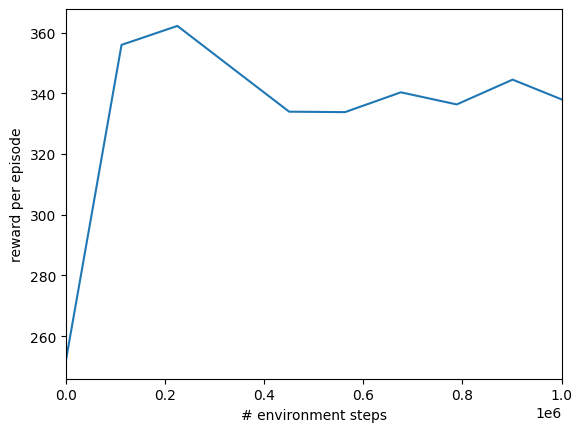

time to jit: 0:00:42.944055
time to train: 0:01:15.934173


In [ ]:
#@title Training

# 강화 학습 훈련 함수 설정 및 파라미터 전달
train_fn = {
    'humanoid': functools.partial(sac.train,
                                  num_timesteps=10_000_00,
                                  num_evals=10,
                                  reward_scaling=0.1,
                                  episode_length=1000,
                                  normalize_observations=True,
                                  action_repeat=1,
                                  discounting=0.97,
                                  learning_rate=3e-4,
                                  num_envs=2048,
                                  batch_size=1024,
                                  seed=1),
  }[env_name]

# y축 최대값 설정
max_y = {'humanoid': 13000}[env_name]

xdata, ydata = [], []
times = [datetime.now()]

# 학습 과정을 시각화하는 함수 (그래프)
def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

# 훈련 시작
make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

# 학습에 걸린 시간 출력
print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

In [ ]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))